# Прошу меня извинить, только вчера поздно вечером влился в поток. Поэтому делаю без "изысков", в рамках уже проделанных заданий.

# Знакомство с данными и агрегация

In [74]:
from datetime import date, datetime, timedelta
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import calendar

В каждом из файлов содержится следующая информация о поездках:

| Code | Value   |
|------|------|
|tpep_pickup_datetime | время начала поездки|
|tpep_dropoff_datetime | время окончания поездки|
|pickup_longitude pickup_latitude | долгота и широта точки начала поездки|
|dropoff_longitude dropoff_latitude | долгота и широта точки окончания поездки|
|passenger_count | количество пассажиров|
|trip_distance | расстояние по счётчику|
|RatecodeID | тип тарифа (одна из шести категорий)|
|payment_type | способ оплаты (одна из шести категорий)|
|fare_amount | стоимость поездки по счётчику|
|extra | налог на счётчик|
|mta_tax | доплата за поездки в пиковые часы и ночью|
|tolls_amount | доплата за проезд по платным дорогам|
|improvement_surcharge | доплата за проезд, взимаемая с каждой поездки с января 2015|
|tip_amount | размер чаевых|
|total_amount | общая стоимость поездки|
|VendorID | провайдер данных (одна из двух категорий)|
|store_and_fwd_flag | бинарный флаг, показывающий, были ли данные о поезде получены немедленно после её окончания, или какое-то время хранились в памяти автомобиля.|



In [4]:
# Загрузим регионы
regions=pd.read_csv('regions.csv',sep=';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


## Загрузим данные за май 2016 года

In [4]:
curyear='2016'
curmonth='05'
data=pd.read_csv('yellow_tripdata_'+curyear+'-'+curmonth+'.csv')
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


## Проведим фильтрацию данных

In [33]:
# Функция выполняет фильтрацию переданного датасета, удаляя бесполезные данные о поездках
def filter_trips(data):
    # Оставляем поездки с ненулевой длительностью
    fil=((data.tpep_dropoff_datetime>data.tpep_pickup_datetime)&
    # Оставляем поездки с ненулевым количеством пассажиров
    (data.passenger_count>0)& 
    # Оставляем поездки с ненулевым расстоянием поездки по счётчику
    (data.trip_distance>0)& 
    # Оставляем поездки с координатами начала, попадающими в прямоугольник Нью-Йорка
    #  от -74.25559 до -73.70001 градусов долготы
    # от 40.49612 до 40.91553 широты.
    (data.pickup_longitude>=-74.25559)&(data.pickup_longitude<=-73.70001)&(data.pickup_latitude>=40.49612)&(data.pickup_latitude<=40.91553))
    return data[fil]

In [6]:
# Применяем фильтр
data=filter_trips(data)
data.shape

(11626521, 19)

## Агрегируем данные за месяц по часам и областям 

In [34]:
# Функция преобразует координаты в номер региона
def coord_to_region(latitude,longitude):
    def normalize_longitude(longitude):
        lo_step=0.011111600000000124
        lo_min=-74.255589999999998
        return np.floor((longitude-lo_min)/lo_step)
    def normalize_latitude(latitude):
        la_step=0.008388199999999983
        la_min= 40.496119999999998
        return np.floor((latitude-la_min)/la_step)
    return normalize_latitude(latitude)+50*normalize_longitude(longitude)

In [35]:
# Функция преобразует дату к числовому виду yyyymmddhh для дальнейшего использования при агрегации 
def datetime_to_int(dt):
    return 1000000*dt.year + 10000*dt.month + 100*dt.day+dt.hour

# Функция формирует перечень дат в числовом виде yyyymmddhh за период с первое по последнее число 
# месяца month в году year с шагом 1 час
def gen_range(year,month,adddays,addhours):
    def perdelta(start, end, delta):
        curr = start
        while curr < end:
            yield curr
            curr += delta
    last_day= datetime(year,month,calendar.monthrange(year,month)[1])+timedelta(days=adddays,hours=addhours)
    datetime_range=[]  
    for result in perdelta(datetime(year, month, 1), last_day, timedelta(hours=1)):
        datetime_range.append(datetime_to_int(result))
    return datetime_range

In [45]:
# Фуникция вычисляет агрегированные данные по часу и региону посадки
def get_arg_data(data,year,month):
    # Преобразовываем тип колонок к типу дата
    data.tpep_pickup_datetime= pd.to_datetime(data.tpep_pickup_datetime)
    data.tpep_dropoff_datetime= pd.to_datetime(data.tpep_dropoff_datetime)
    # Строим новую колонку - час посадки                           
    data['z_tpep_pickup_hour']=data.tpep_pickup_datetime.apply(datetime_to_int)
    # Вычисляем регион посадки                                          
    data['z_region_id']=coord_to_region(data.pickup_latitude,data.pickup_longitude)
    # Строим таблицу Час-Регион. В ячейках таблице количество посадок в такси за данный час в данном регионе                                           
    binx = gen_range(int(year),int(month),1,1)
    biny=np.append(regions.region.values,regions.region.values.max()+1)
    ret=stats.binned_statistic_2d(data.z_tpep_pickup_hour.values,data.z_region_id.values,None, 'count', bins=[binx,biny])
    # Преобразуем индекс к дате
    df=pd.DataFrame(ret.statistic,index=gen_range(int(year),int(month),1,0),columns=regions.region.values)                                           
    df.index=df.index.map(lambda x:datetime.strptime(str(x), "%Y%m%d%H"))
    df.index.names = ['dt']
    # Возвращем полученную таблицу
    return df

In [ ]:
# Выполняем агрегацию
agr_data=get_arg_data(data,curyear,curmonth)
agr_data.to_csv('arg_data_may.csv',sep=';')

## Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

In [33]:
agr_data.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
dt,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

In [4]:
agr_data=pd.read_csv('arg_data.csv',sep=';')
agr_data.head()

,dt,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


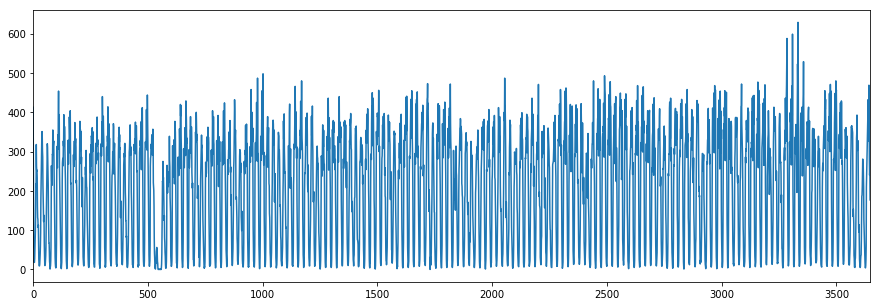

In [18]:
plt.figure(figsize=[15,5])
#plt.figure(figsize(15,7))
agr_data['1282'].plot()

Оптимальный параметр преобразования Бокса-Кокса: 0.577122


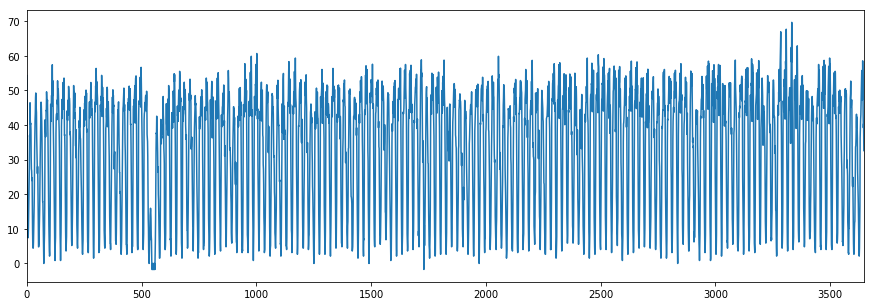

In [46]:
agr_data['salary_box'], lmbda   = stats.boxcox(np.abs(agr_data['1282'])+1.e-6)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
plt.figure(figsize=[15,5])
#plt.figure(figsize(15,7))
agr_data['salary_box'].plot()

In [39]:
arg_data_may=pd.read_csv('arg_data_may.csv',sep=';')
(arg_data_may==0).sum().sum()

1718238

In [53]:
(arg_data_may==0).sum()

dt        0
1       744
2       744
3       744
4       744
5       744
6       744
7       744
8       744
9       744
10      744
11      744
12      744
13      744
14      743
15      743
16      744
17      744
18      744
19      744
20      744
21      744
22      744
23      744
24      743
25      744
26      743
27      744
28      744
29      744
       ... 
2471    741
2472    738
2473    743
2474    744
2475    742
2476    744
2477    740
2478    740
2479    744
2480    740
2481    739
2482    742
2483    743
2484    742
2485    741
2486    742
2487    744
2488    744
2489    744
2490    744
2491    744
2492    744
2493    744
2494    744
2495    744
2496    744
2497    744
2498    744
2499    744
2500    744
Length: 2501, dtype: int64

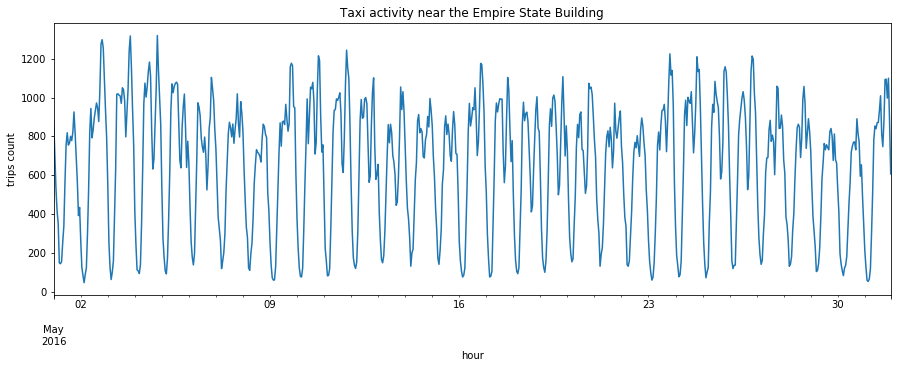

In [32]:


# Коррдинаты и регион ESB
esb_latitude = 40.748817
esb_longitude = -73.985428
esb_region=coord_to_region(esb_latitude,esb_longitude)
# Строим график
plt.figure(figsize=[15,5])
agr_data[esb_region].plot()
plt.title('Taxi activity near the Empire State Building')
plt.xlabel('hour')
plt.ylabel('trips count')
plt.show()

## Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [49]:
(agr_data>0).sum().sum()

687429

In [50]:
(agr_data<0).sum().sum()

12

In [72]:
agr_data=pd.read_csv('arg_data.csv',sep=';')
agr_data.head()
bbb=np.array(agr_data)


In [73]:
agr_data.head()

,dt,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
0,2016-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
print bbb.shape

(3648L, 2502L)


In [71]:
print bbb[0:10,2492:2502]

[[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 54.30170188404889]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 46.104459074185165]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 29.258464836844396]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 16.135701176213384]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 15.213600943380161]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.454352038275713]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7.454352038275713]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 10.122747160348881]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 14.448580632521768]
 [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 18.3850064924984]]


In [63]:
bbb= agr_data[agr_data<0].index


In [64]:
print bbb

RangeIndex(start=0, stop=3648, step=1)


In [51]:
(agr_data==0).sum().sum()

8439855

In [54]:
(arg_data_may==0).sum().sum()

1718238

In [55]:
(arg_data_may>0).sum().sum()

142506

In [56]:
(arg_data_may<0).sum().sum()

0

# Формируем агрегированные данные за период (полгода)

In [37]:
def get_agr(year,month):
    data=pd.read_csv('yellow_tripdata_'+year+'-'+month+'.csv')
    data=filter_trips(data)
    agr_data=get_arg_data(data,year,month)
    return agr_data

In [49]:
arg_data=pd.DataFrame()
for year in ['2016']:
    for month in ['01','02','03','04','05']:
        arg_data=pd.concat([arg_data,get_agr(year,month)])
arg_data.shape

(3648, 2500)

In [50]:
arg_data.to_csv('arg_data.csv',sep=';')

In [76]:
s =pd.Series(np.random.randn(5),index=['a','b','c','d','e'])

In [77]:
s


a   -0.379685
b   -1.171591
c   -0.224367
d   -0.765174
e    0.662566
dtype: float64

In [79]:
print s +s[1:]

a         NaN
b   -2.343181
c   -0.448734
d   -1.530348
e    1.325132
dtype: float64


In [80]:
print s

a   -0.379685
b   -1.171591
c   -0.224367
d   -0.765174
e    0.662566
dtype: float64


In [81]:
print s[1:]

b   -1.171591
c   -0.224367
d   -0.765174
e    0.662566
dtype: float64


In [88]:
df =pd.DataFrame(np.random.randn(8,3),index=pd.date_range('13/2/2000',periods=8),columns=['A','B','C'])

In [89]:
df

,A,B,C
2000-02-13,-0.594740,0.711208,-0.652969
2000-02-14,-3.594350,-1.311359,-0.244859
2000-02-15,0.057098,0.850161,-0.528010
2000-02-16,-0.354014,0.032245,0.016926
2000-02-17,1.535228,1.222286,1.431104
2000-02-18,-1.358043,2.341506,-0.584544
2000-02-19,-0.436663,-0.638461,0.027841
2000-02-20,0.907859,-0.024052,-0.126959


In [90]:
df =pd.DataFrame(np.random.randn(8,3),index=pd.date_range('12/2/2000',periods=8),columns=['A','B','C'])

In [91]:
df

,A,B,C
2000-12-02,-0.192210,0.897901,0.511244
2000-12-03,1.350043,0.653058,1.095441
2000-12-04,-0.173059,0.573104,-2.357769
2000-12-05,-0.572823,-1.158098,-0.092741
2000-12-06,0.934693,0.157060,2.093381
2000-12-07,0.892081,-0.060797,0.849119
2000-12-08,0.414491,0.208440,0.292175
2000-12-09,-0.025640,-0.061544,0.877680


In [92]:
wp =pd.Panel(np.random.randn(2,5,4),items=['Item1','Item2'],major_axis=pd.date_range('1/1/2000',periods=5),minor_axis=['A','B','C','D'])

C:\Users\hp\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2878: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [93]:
wp

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 5 (major_axis) x 4 (minor_axis)
Items axis: Item1 to Item2
Major_axis axis: 2000-01-01 00:00:00 to 2000-01-05 00:00:00
Minor_axis axis: A to D